In [1]:
import shutil
import PySimpleGUI as sg
import numpy as np
from PIL import Image, ImageTk
import threading, os, time
import warnings

from upsampling import *
import metrics as mx

norm = lambda x: (x - x.min()) / (x.max() - x.min())

import disp2points as disp

import matplotlib.pyplot as plt

import filters as flt

import pandas as pd

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [2]:
layout = [[sg.Text('3D Computer Vision', font='Helvetica 20 bold', text_color='black', background_color='white',
                   pad=(10, 10))],
          [sg.Text('Homework 2', font='Helvetica 14', text_color='black', background_color='white', pad=(10, 10))],
          [sg.Button('Filtering', size=(20, 2), button_color=('white', 'black'), pad=(10, 10)),
           sg.Button('Upsampling', size=(20, 2), button_color=('white', 'black'), pad=(10, 10)),
           sg.Button('Process All Dataset', size=(20, 2), button_color=('white', 'black'), pad=(10, 10))],
          [sg.Text('Tarlan Ahadli', justification='right', font='Helvetica 9', text_color='black',
                   background_color='white', pad=(10, 50))]]

# Create the window
main_window = sg.Window('3D Computer Vision Homework 2', layout, margins=(0, 200), size=(1000, 700),
                        background_color='white', element_justification='center')

# Event loop
while True:
    event, values = main_window.read()

    if event in (sg.WIN_CLOSED, 'Button 1', 'Button 2', 'Button 3'):
        break

main_window.close()

TclError: no display name and no $DISPLAY environment variable

In [6]:
def get_window_layer():
    first_column = [
        [sg.Button('Get original image', size=(54, 2), pad=((0, 0), (50, 0)))],
        [sg.Image(filename='', key='original image', size=(430, 430), background_color='#DDDDDD')],
        [sg.InputText(key='mean', size=(30, 1), justification="center", default_text='mean'),
         sg.InputText(key='std', size=(30, 1), justification="center", default_text='std')],
        [sg.Button('Add Noise', size=(54, 2))],
        [sg.Button('Save', size=(54, 2))]
    ]

    second_column = [
        [
            sg.InputText(default_text='win size b', key='win size b', size=(20, 1), justification="center",
                         pad=((0, 0), (50, 0))),
            sg.InputText(default_text='spat sig b', key='spat sig b', size=(20, 1), justification="center",
                         pad=((0, 0), (50, 0))),
            sg.InputText(default_text='spec sig b', key='spec sig b', size=(20, 1), justification="center",
                         pad=((0, 0), (50, 0)))],
        [sg.Button(button_text='Bilateral Filtering', key='Bilateral Filtering', size=(56, 2))],

        [sg.InputText(default_text='win size jb', key='win size jb', size=(20, 1), justification="center"),
         sg.InputText(default_text='spat sig jb', key='spat sig jb', size=(20, 1), justification="center"),
         sg.InputText(default_text='spec sig jb', key='spec sig jb', size=(20, 1), justification="center")],
        [sg.Button(button_text='Browse Guide Image', key='Guide Image', size=(27, 2)),
         sg.Button(button_text='Joint Bilateral', key='Joint Bilateral', size=(27, 2))],
        [sg.Text('path' + ''.join([' ' for _ in range(120)]),
                 justification='left', font='Helvetica 8', text_color='black', background_color='white',
                 key='guide_path_text')],

        [sg.Image(filename='', key='filtered_image', size=(430, 430), background_color='#DDDDDD')]
    ]

    layout = [
        [
            sg.Column(first_column, justification='center', element_justification='center', background_color='white'),
            sg.VSeperator(pad=((0, 0), (50, 0))),
            sg.Column(second_column, justification='center', element_justification='center', background_color='white'),
        ]
    ]

    # Create the window
    window = sg.Window('Window Title', layout, size=(1000, 700),
                       background_color='white',
                       element_justification='center',
                       button_color=('white', 'black'))

    return window

In [7]:


warnings.filterwarnings('ignore')

window = get_window_layer()
event, values = window.read()

img_size = 430
original_img = None
noisy_img = None
guide_image_path = None
filtered_image_bil = None
filtered_image_jon_bil = None
jb_tm = -1
b_tm = -1

while True:
    event, values = window.read()

    if event == 'Get original image':
        file_path = sg.popup_get_file('Choose Image', file_types=(("JPEG", "*.jpg"), ("PNG", "*.png")))
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(image, (img_size, img_size))
        window['original image'].update(data=ImageTk.PhotoImage(image=Image.fromarray(original_img)))

    if event == 'Add Noise':
        if original_img is not None:
            m = float(values['mean'])
            std = float(values['std'])
            gaussian = np.random.normal(m, std, size=original_img.shape)
            noisy_img = (original_img + gaussian)
            noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
            window['original image'].update(data=ImageTk.PhotoImage(image=Image.fromarray(noisy_img)))

    if event == 'Bilateral Filtering':
        if noisy_img is not None:
            win_size = int(values['win size b'])
            spat_sig = float(values['spat sig b'])
            spec_sig = float(values['spec sig b'])


            def t():
                global filtered_image_bil, b_tm
                print('---------------------------')
                print('Bilateral Filtering Started!');
                start = timer();
                filtered_image_bil = np.stack((
                    get_bilateral_output(noisy_img[:, :, 0], spec_sig=spec_sig, spat_sig=spat_sig,
                                         window_size=win_size),
                    get_bilateral_output(noisy_img[:, :, 1], spec_sig=spec_sig, spat_sig=spat_sig,
                                         window_size=win_size),
                    get_bilateral_output(noisy_img[:, :, 2], spec_sig=spec_sig, spat_sig=spat_sig,
                                         window_size=win_size)),
                    axis=2).round()
                filtered_image_bil = np.clip(filtered_image_bil, 0, 255).astype(np.uint8)

                window['filtered_image'].update(data=ImageTk.PhotoImage(image=Image.fromarray(filtered_image_bil)))
                print('---------Finished----------')
                b_tm = timer() - start


            x = threading.Thread(target=t, args=())
            x.start()

    if event == 'Guide Image':
        guide_image_path = sg.popup_get_file('Choose Image', file_types=(("JPEG", "*.jpg"), ("PNG", "*.png")))
        window['guide_path_text'].update(guide_image_path)

    if event == 'Joint Bilateral':
        if noisy_img is not None and guide_image_path is not None:
            win_size = int(values['win size jb'])
            spat_sig = float(values['spat sig jb'])
            spec_sig = float(values['spec sig jb'])


            def t():
                global filtered_image_jon_bil, jb_tm
                print('---------------------------')
                print('Joint Bilateral Filtering Started!');
                start = timer();
                guided_img = cv2.imread(guide_image_path)
                guided_img = cv2.cvtColor(guided_img, cv2.COLOR_BGR2GRAY)
                guided_img = cv2.resize(guided_img, (img_size, img_size))

                filtered_image_jon_bil = np.stack((
                    get_joint_bilateral_out(guided_img, noisy_img[:, :, 0], spec_sig=spec_sig, spat_sig=spat_sig,
                                            window_size=win_size),
                    get_joint_bilateral_out(guided_img, noisy_img[:, :, 1], spec_sig=spec_sig, spat_sig=spat_sig,
                                            window_size=win_size),
                    get_joint_bilateral_out(guided_img, noisy_img[:, :, 2], spec_sig=spec_sig, spat_sig=spat_sig,
                                            window_size=win_size)),
                    axis=2).round()
                filtered_image_jon_bil = np.clip(filtered_image_jon_bil, 0, 255).astype(np.uint8)
                window['filtered_image'].update(data=ImageTk.PhotoImage(image=Image.fromarray(filtered_image_jon_bil)))
                print('---------Finished----------')
                jb_tm = timer() - start


            x = threading.Thread(target=t, args=())
            x.start()

    if event == 'Save':
        print('------Saving Images---------')
        new_path = 'files/images/output/' + time.ctime().replace(':', '_')
        os.makedirs(new_path)
        for img, name in zip([original_img, noisy_img, filtered_image_bil, filtered_image_jon_bil],
                             ['original', 'noizy', 'filtered_bil', 'filtered_biljon']):
            if img is not None:
                cv2.imwrite(new_path + '/' + name + '.png', img)

                np.savetxt(new_path + '/' + 'filtering_time_log.txt',
                           X=np.array([['B Filtering', str(np.round(b_tm).astype(int))],
                                       ['JB Filtering', str(np.round(jb_tm).astype(int))]]).astype(object),
                           delimiter=' ',
                           fmt='%s')

        print('--------Saved----------------')

    if event == sg.WIN_CLOSED:
        break

window.close()

In [2]:
img_size = 200
m = 0
std = 15
i = 1

file_path = 'files/images/input/{}/ground.png'.format(i)
img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (img_size, img_size)).astype(float)

gaussian = np.random.normal(m, std, size=img.shape)
noisy_img = (img + gaussian)
noisy_img = (np.clip(noisy_img, 0, 255).astype(float))

guide_img_path = 'files/images/input/{}/view0.png'.format(i)
guide_img = cv2.cvtColor(cv2.imread(guide_img_path), cv2.COLOR_BGR2GRAY)
guide_img = cv2.resize(guide_img, (img_size, img_size)).astype(float)

In [3]:
mx.ssim(norm(img), norm(noisy_img))

0.6029316448899738

In [4]:
filt_img = flt.get_bilateral_output(noisy_img, 5, 5, 5)
mx.ssim(norm(img), norm(filt_img))

100%|██████████| 196/196 [00:10<00:00, 19.56it/s]


0.812436953892852

In [6]:
filt_img = flt.get_joint_bilateral_out(guide_img, noisy_img, 5, 5, 5)
mx.ssim(norm(img), norm(filt_img))

100%|██████████| 196/196 [00:10<00:00, 19.57it/s]


0.8395624207468754

# Evaluation of algorithms

## Bilet. Filt.

In [3]:
img_size = 200
m = 0
std = 15

bilet_joint_result = []
for i in range(1, 13):

    file_path = 'files/images/input/{}/ground.png'.format(i)
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size, img_size)).astype(float)

    gaussian = np.random.normal(m, std, size=img.shape)
    noisy_img = (img + gaussian)
    noisy_img = (np.clip(noisy_img, 0, 255).astype(float))

    guide_img_path = 'files/images/input/{}/view0.png'.format(i)
    guide_img = cv2.cvtColor(cv2.imread(guide_img_path), cv2.COLOR_BGR2GRAY)
    guide_img = cv2.resize(guide_img, (img_size, img_size)).astype(float)

    c = 0
    for window_size in [3, 5, 7]:
        for spat_sigma in [5, 10, 15]:
            for spec_sigma in [5, 10, 15]:
                bil_img, bil_tm = flt.get_bilateral_output(noisy_img, spec_sig=spec_sigma, spat_sig=spat_sigma,
                                                           window_size=window_size,
                                                           return_time=True,
                                                           show_tqdm=False)

                jbil_img, jbil_tm = flt.get_joint_bilateral_out(guide_img, noisy_img,
                                                                spec_sig=spec_sigma,
                                                                spat_sig=spat_sigma,
                                                                window_size=window_size,
                                                                return_time=True,
                                                                show_tqdm=False)

                row = [i, window_size, spat_sigma, spec_sigma, img, noisy_img, bil_img, bil_tm, jbil_img, jbil_tm]

                row += [func(norm(img), norm(noisy_img)) for mx_name, func in
                        zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                            [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]

                row += [func(norm(img), norm(bil_img)) for mx_name, func in
                        zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                            [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]

                row += [func(norm(img), norm(jbil_img)) for mx_name, func in
                        zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                            [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]

                c += 1

                bilet_joint_result.append(row)

                print({'img_idx': i, 'params': [window_size, spat_sigma, spec_sigma]}, {c}, end='\r')

KeyboardInterrupt: 

In [2]:
import pickle

#with open('files/bilet_joint_result.pickle', 'wb') as handle:
#    pickle.dump(bilet_joint_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('files/bilet_joint_result.pickle', 'rb') as handle:
    bilet_joint_result = pickle.load(handle)

In [3]:

cls = 'idx, window_size, spat_sigma, spec_sigma, img, noisy_img, bil_img, bil_tm, jbil_img, jbil_tm'.split(', ')
cls += ['noisy_' + s for s in ['ssd ', 'mse ', 'psnr', 'corr', 'ssim']]
cls += ['bil_' + s for s in ['ssd ', 'mse ', 'psnr', 'corr', 'ssim']]
cls += ['joint_bil_' + s for s in ['ssd ', 'mse ', 'psnr', 'corr', 'ssim']]

bilet_joint_df = pd.DataFrame(bilet_joint_result, columns=cls)

In [4]:

# Load your data into a pandas dataframe
df = bilet_joint_df

# Set up the bar plot
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)

rects = ax.bar([1, 2, 3], df.loc[0, ['noisy_ssim', 'bil_ssim', 'joint_bil_ssim']], color=['r', 'g', 'b'])
ax.set_xticks([1, 2, 3])

cls = ['noisy_ssim', 'bil_ssim', 'joint_bil_ssim']
ax.set_xticklabels(cls)
ax.set_title("Simulation Metrics")

# Add the sliders
b = 0
ax_idx = plt.axes([0.25, b, 0.65, 0.03])
ax_window_size = plt.axes([0.25, b + 0.05, 0.65, 0.03])
ax_spat_sigma = plt.axes([0.25, b + 2 * 0.05, 0.65, 0.03])
ax_spec_sigma = plt.axes([0.25, b + 3 * 0.05, 0.65, 0.03])

slider_idx = Slider(ax_idx, "idx", df["idx"].min(), df["idx"].max(), valinit=df["idx"].min(), valstep=1)

slider_window_size = Slider(ax_window_size, "window_size", df["window_size"].min(), df["window_size"].max(),
                            valinit=df["window_size"].min(), valstep=2)
slider_spat_sigma = Slider(ax_spat_sigma, "spat_sigma", df["spat_sigma"].min(), df["spat_sigma"].max(),
                           valinit=df["spat_sigma"].min(), valstep=5)
slider_spec_sigma = Slider(ax_spec_sigma, "spec_sigma", df["spec_sigma"].min(), df["spec_sigma"].max(),
                           valinit=df["spec_sigma"].min(), valstep=5)


# Define the update function
def update(val):
    idx = int(slider_idx.val)
    window_size = int(slider_window_size.val)
    spat_sigma = int(slider_spat_sigma.val)
    spec_sigma = int(slider_spec_sigma.val)
    row = df[(df["idx"] == idx) & (df["window_size"] == window_size) & (df["spat_sigma"] == spat_sigma) & (
                df["spec_sigma"] == spec_sigma)]
    for i, rect in enumerate(rects):
        rect.set_height(float(row[cls[i]]))
    fig.canvas.draw_idle()


# Connect the update function to the sliders
slider_idx.on_changed(update)
slider_window_size.on_changed(update)
slider_spat_sigma.on_changed(update)
slider_spec_sigma.on_changed(update)

plt.show()


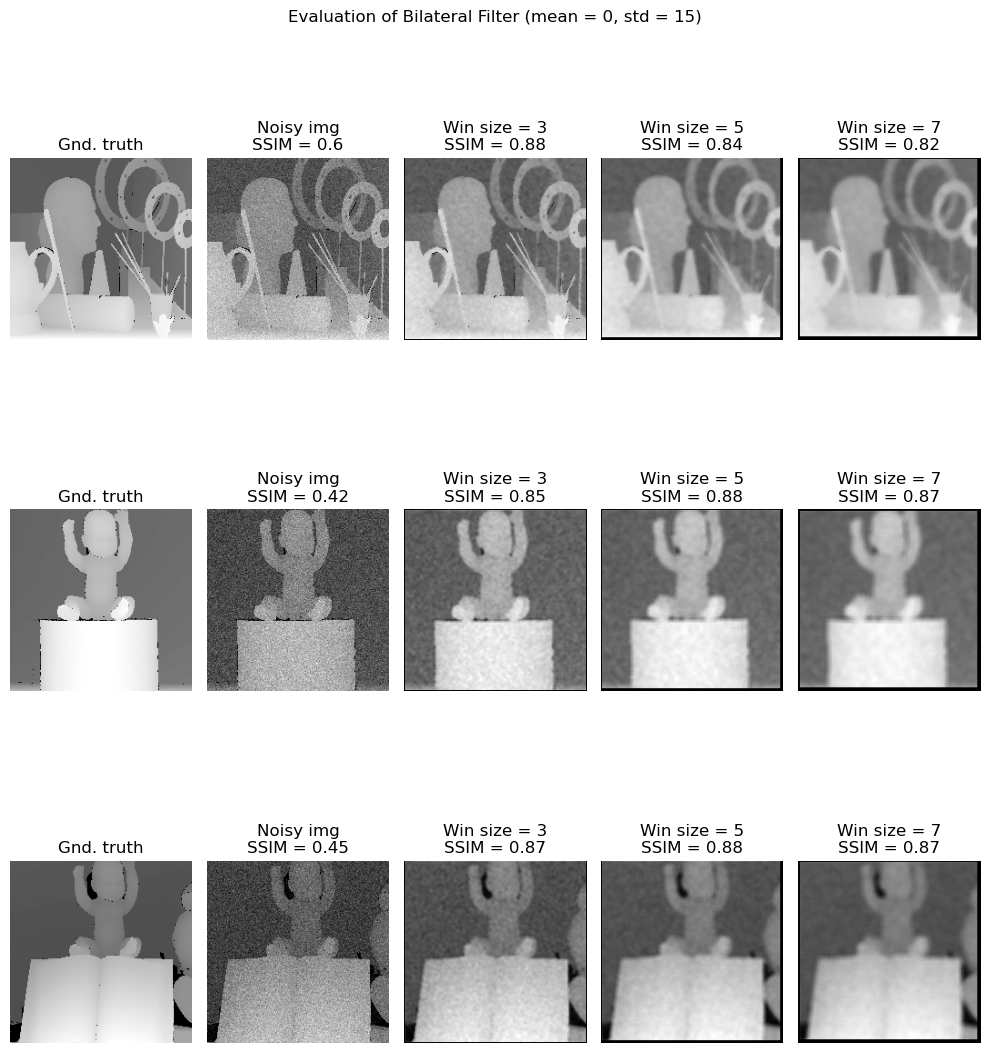

In [10]:
%matplotlib inline
s = 3
fig, ax = plt.subplots(s, 5, figsize=(10, s*4), tight_layout=True)

for idx in range(1,s+1):
    img = bilet_joint_df[bilet_joint_df['idx']==idx].iloc[0]['img']
    ax[idx-1,0].imshow(img,cmap='gray')
    ax[idx-1,0].axis('off')
    ax[idx-1,0].set_title("Gnd. truth")


    noisy_img = bilet_joint_df[bilet_joint_df['idx']==idx].iloc[0]['noisy_img']
    ax[idx-1,1].imshow(noisy_img,cmap='gray')
    ax[idx-1,1].axis('off')

    noisy_ssim = bilet_joint_df[bilet_joint_df['idx']==idx].iloc[0]['noisy_ssim']

    ax[idx-1,1].set_title("Noisy img\nSSIM = {0}".format(np.round(noisy_ssim,2)))



    for i,win_size in enumerate([3,5,7]):
        df_min = bilet_joint_df[np.logical_and(bilet_joint_df['window_size']==win_size,bilet_joint_df['idx']==idx)]
        row = df_min.iloc[df_min['bil_ssim'].argmax()]
        img = row['bil_img']

        ax[idx-1,i+2].imshow(img,cmap='gray')
        ax[idx-1,i+2].axis('off')
        ax[idx-1,i+2].set_title("Win size = {0}\nSSIM = {1}".format(row['window_size'],np.round(row['bil_ssim'],2)))
plt.suptitle('Evaluation of Bilateral Filter (mean = 0, std = 15)')
plt.show()

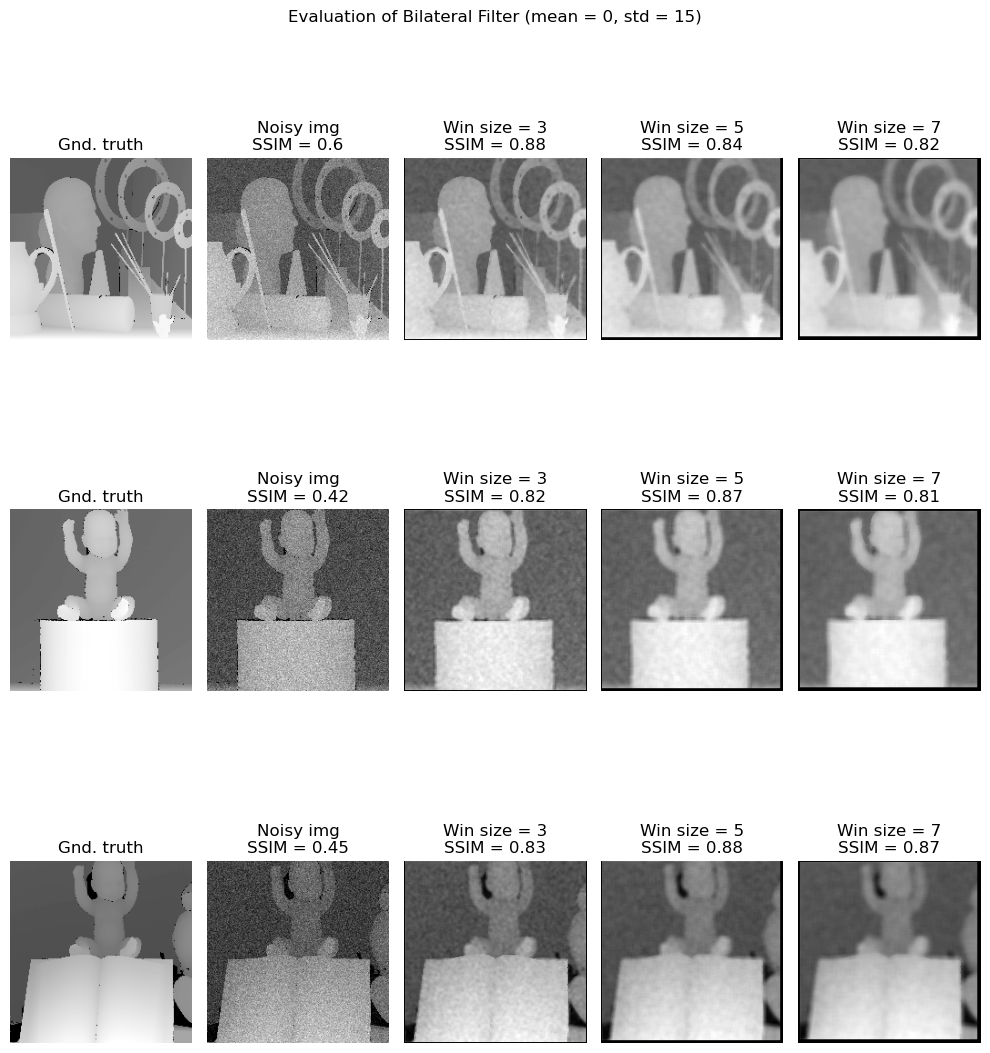

In [11]:
%matplotlib inline
s = 3
fig, ax = plt.subplots(s, 5, figsize=(10, s*4), tight_layout=True)

for idx in range(1,s+1):
    img = bilet_joint_df[bilet_joint_df['idx']==idx].iloc[0]['img']
    ax[idx-1,0].imshow(img,cmap='gray')
    ax[idx-1,0].axis('off')
    ax[idx-1,0].set_title("Gnd. truth")


    noisy_img = bilet_joint_df[bilet_joint_df['idx']==idx].iloc[0]['noisy_img']
    ax[idx-1,1].imshow(noisy_img,cmap='gray')
    ax[idx-1,1].axis('off')

    noisy_ssim = bilet_joint_df[bilet_joint_df['idx']==idx].iloc[0]['noisy_ssim']

    ax[idx-1,1].set_title("Noisy img\nSSIM = {0}".format(np.round(noisy_ssim,2)))



    for i,win_size in enumerate([3,5,7]):
        df_min = bilet_joint_df[np.logical_and(bilet_joint_df['window_size']==win_size,bilet_joint_df['idx']==idx)]
        row = df_min.iloc[df_min['joint_bil_ssim'].argmax()]
        img = row['jbil_img']

        ax[idx-1,i+2].imshow(img,cmap='gray')
        ax[idx-1,i+2].axis('off')
        ax[idx-1,i+2].set_title("Win size = {0}\nSSIM = {1}".format(row['window_size'],np.round(row['bil_ssim'],2)))
plt.suptitle('Evaluation of Bilateral Filter (mean = 0, std = 15)')
plt.show()

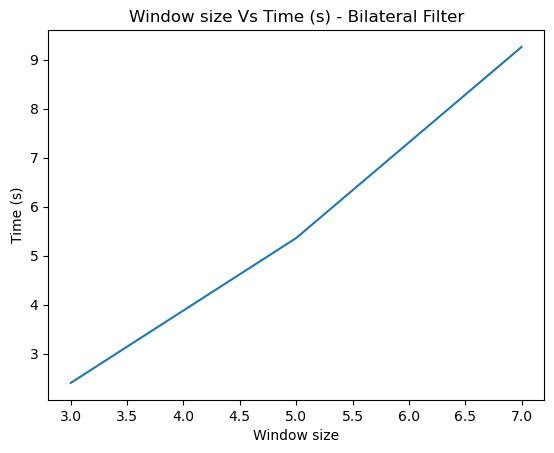

In [12]:
plt.plot([3,5,7], [bilet_joint_df[bilet_joint_df['window_size']==i]['bil_tm'].mean() for i in [3,5,7]])
plt.title('Window size Vs Time (s) - Bilateral Filter')
plt.xlabel('Window size')
plt.ylabel('Time (s)')
plt.show()

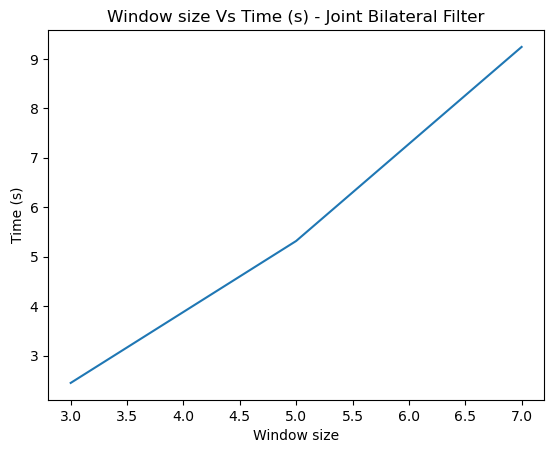

In [14]:
plt.plot([3,5,7], [bilet_joint_df[bilet_joint_df['window_size']==i]['jbil_tm'].mean() for i in [3,5,7]])
plt.title('Window size Vs Time (s) - Joint Bilateral Filter')
plt.xlabel('Window size')
plt.ylabel('Time (s)')
plt.show()

# Upsampling

In [7]:
%matplotlib inline

img_size = 200
m = 0
std = 15

bilet_joint_result = []
i = 1
window_size = 5
spat_sigma = 5
spec_sigma = 5

file_path = 'files/images/input/{}/ground.png'.format(i)
img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (img_size, img_size)).astype(float)

low_img = cv2.resize(img, (img_size//2, img_size//2)).astype(float)

gaussian = np.random.normal(m, std, size=(img_size//2, img_size//2))
noisy_img = (low_img + gaussian)
noisy_img = (np.clip(noisy_img, 0, 255).astype(float))

guide_img_path = 'files/images/input/{}/view0.png'.format(i)
guide_img = cv2.cvtColor(cv2.imread(guide_img_path), cv2.COLOR_BGR2GRAY)
guide_img = cv2.resize(guide_img, (img_size, img_size)).astype(float)

In [11]:
img_size = 200
m = 0
std = 15

joint_ups_result = []
for i in range(1, 13):

    file_path = 'files/images/input/{}/ground.png'.format(i)
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size, img_size)).astype(float)

    low_img = cv2.resize(img, (img_size//2, img_size//2)).astype(float)

    gaussian = np.random.normal(m, std, size=(img_size//2, img_size//2))
    noisy_img = (low_img + gaussian)
    noisy_img = (np.clip(noisy_img, 0, 255).astype(float))

    guide_img_path = 'files/images/input/{}/view0.png'.format(i)
    guide_img = cv2.cvtColor(cv2.imread(guide_img_path), cv2.COLOR_BGR2GRAY)
    guide_img = cv2.resize(guide_img, (img_size, img_size)).astype(float)

    c = 0
    for window_size in [3, 5, 7]:
        for spat_sigma in [5, 10, 15]:
            for spec_sigma in [5, 10, 15]:

                joint_ups_img,joint_ups_tm = get_joint_upsampling_out(guide_img,noisy_img,w_size=window_size,spat_sig=spat_sigma,spec_sig=spec_sigma,return_time=True,show_tqdm=False)

                joint_iter_ups_img,joint_iter_ups_tm = get_iterative_upsampling_out(guide_img,noisy_img,w_size=window_size,spat_sig=spat_sigma,spec_sig=spec_sigma,return_time=True,show_tqdm=False)

                row = [i, window_size, spat_sigma, spec_sigma, img, noisy_img, joint_ups_img,joint_ups_tm, joint_iter_ups_img, joint_iter_ups_tm]

                row += [func(norm(img), norm(joint_ups_img)) for mx_name, func in
                        zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                            [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]

                row += [func(norm(img), norm(joint_iter_ups_img)) for mx_name, func in
                        zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                            [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]


                c += 1

                joint_ups_result.append(row)

                print({'img_idx': i, 'params': [window_size, spat_sigma, spec_sigma]}, {c}, end='\r')

KeyboardInterrupt: 

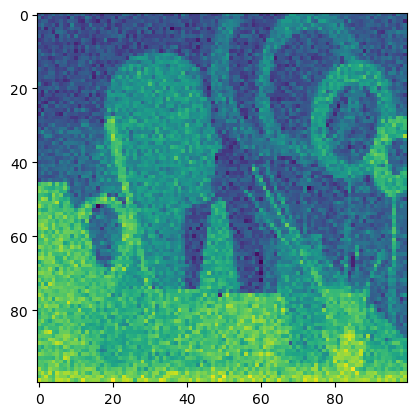

In [10]:
plt.imshow(noisy_img)

In [9]:
def get_upsampled_image(name, filtering_func, low_depth_image_path, hi_depth_image_path, original_rgb_path,
                        w_size=5, spat_sig=8, spec_sig=2, get_metric=False):
    low_depth_image = cv2.cvtColor(cv2.imread(low_depth_image_path), cv2.COLOR_BGR2RGB)
    hi_depth_image = cv2.cvtColor(cv2.imread(hi_depth_image_path), cv2.COLOR_BGR2RGB)
    original_rgb = cv2.cvtColor(cv2.imread(original_rgb_path), cv2.COLOR_BGR2RGB)

    start = timer()
    up_image = np.stack((
        filtering_func(original_rgb[:, :, 0], low_depth_image[:, :, 0], w_size, spat_sig, spec_sig),
        filtering_func(original_rgb[:, :, 1], low_depth_image[:, :, 1], w_size, spat_sig, spec_sig),
        filtering_func(original_rgb[:, :, 2], low_depth_image[:, :, 2], w_size, spat_sig, spec_sig)),
        axis=2).round()
    up_image = np.clip(up_image, 0, 255).astype(np.uint8)

    log = []
    log.append([name, '----'])
    log.append(['time', timer() - start])
    for mx_name, func in zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'], [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim]):
        h_a = int((hi_depth_image.shape[0] - up_image.shape[0]) / 2)
        h_b = hi_depth_image.shape[0] - up_image.shape[0] - h_a

        w_a = int((hi_depth_image.shape[1] - up_image.shape[1]) / 2)
        w_b = hi_depth_image.shape[1] - up_image.shape[1] - w_a

        log.append([mx_name, str(func(hi_depth_image[h_a:-h_b, w_a:-w_b, :], up_image))])

    if get_metric:
        return up_image, log
    return up_image

In [99]:
for current_folder in range(1, 14):
    '''
    new_path = 'files/images/output/' + str(current_folder)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    else:
        shutil.rmtree(new_path)
        os.makedirs(new_path)
    '''
    whole_log = [['-----', '-----']]
    for filtering_func, name in zip([get_joint_upsampling_out, get_iterative_upsampling_out],
                                    ['Joint Ups', 'Iterative Ups']):
        low_depth_image_path = 'files/images/input/{0}/low_disp_ground.png'.format(current_folder)
        hi_depth_image_path = 'files/images/input/{0}/ground.png'.format(current_folder)
        original_rgb_path = 'files/images/input/{0}/view0.png'.format(current_folder)
        print(name, low_depth_image_path)

        up_image, log = get_upsampled_image(name, filtering_func, low_depth_image_path, hi_depth_image_path,
                                            original_rgb_path,
                                            get_metric=True)

        whole_log = np.concatenate((whole_log, log)).tolist()
        whole_log.append(['----', '-----'])
        print(np.array(whole_log))

        cv2.imwrite(new_path + '/' + name + '_out.png', up_image)
        np.savetxt(new_path + '/' + 'log.txt',
                   X=whole_log[1:], delimiter=' ',
                   fmt='%s')

        #up_image = cv2.cvtColor(cv2.imread('files/images/output/{}'.format(current_folder) + '/' + name + '_out.png'),
        #                       cv2.COLOR_BGR2RGB)

        all_points = disp.project_disparity_to_3d(cv2.cvtColor(up_image, cv2.COLOR_RGB2GRAY))
        all_norms = disp.project_disparity_to_3d_norm(cv2.cvtColor(up_image, cv2.COLOR_RGB2GRAY))
        s = 'ply\n\
            format ascii 1.0\n\
            element vertex {0}\n\
            property float x\n\
            property float y\n\
            property float z\n\
            property float nx\n\
            property float ny\n\
            property float nz\nend_header\n'.format(len(all_points))

        for p, n in zip(all_points, all_norms):
            s += ' '.join(["{:0.14f}".format(x) for x in p + n]) + '\n'

        with open('files/images/output/{0}/{1}_points_norm.ply'.format(current_folder, name), 'w') as the_file:
            the_file.write(s)

Joint Ups files/images/input/1/low_disp_ground.png
Iterative Ups files/images/input/1/low_disp_ground.png
Joint Ups files/images/input/2/low_disp_ground.png
Iterative Ups files/images/input/2/low_disp_ground.png
Joint Ups files/images/input/3/low_disp_ground.png
Iterative Ups files/images/input/3/low_disp_ground.png
Joint Ups files/images/input/4/low_disp_ground.png
Iterative Ups files/images/input/4/low_disp_ground.png
Joint Ups files/images/input/5/low_disp_ground.png
Iterative Ups files/images/input/5/low_disp_ground.png
Joint Ups files/images/input/6/low_disp_ground.png
Iterative Ups files/images/input/6/low_disp_ground.png
Joint Ups files/images/input/7/low_disp_ground.png
Iterative Ups files/images/input/7/low_disp_ground.png
Joint Ups files/images/input/8/low_disp_ground.png
Iterative Ups files/images/input/8/low_disp_ground.png
Joint Ups files/images/input/9/low_disp_ground.png
Iterative Ups files/images/input/9/low_disp_ground.png
Joint Ups files/images/input/10/low_disp_groun